## Setup

### Import Libraries

In [64]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import datetime as dt
import numpy as np
import statistics as stats
import pickle
import json
import os
import copy
import inspect

from configdb import configdb
import duration_utils as du

from rise_set.angle import Angle
from rise_set.rates import ProperMotion
from rise_set.visibility import Visibility
from rise_set.astrometry import calculate_airmass_at_times, make_ra_dec_target
from time_intervals.intervals import Intervals

from models import ICRSTarget, OrbitalElementsTarget, SatelliteTarget

from pandas import notna

### Plotting Functions

In [2]:
def scatter(x_values, y_values, title, xlabel, ylabel, filename):
    plt.scatter(x_values, y_values, marker=".", color="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(os.path.join("plots", filename+".png"))
    plt.show()

In [3]:
def histogram(x_values, bin_edges, title, xlabel, ylabel, filename):
    plot = plt.hist(x_values, bin_edges)
    plt.xscale("log")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [4]:
def flat_hist(x_values, bin_edges, bin_names, title, xlabel, ylabel, filename=None):
    data = np.histogram(x_values, bin_edges)
    plot = plt.bar(bin_names, data[0])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [5]:
def split_on_limits(df, column_name, limits):
    counts = []
    for i in range(len(limits)):
        bottom_limit = limits[i]
        if (i+1) < len(limits):
            top_limit = limits[i+1]
        else:
            top_limit = float("inf")
        counts.append(df[(df[column_name]>bottom_limit) & (df[column_name]<=top_limit)].shape[0])

        print(f"{bottom_limit} -> {top_limit}: {counts[i]}")

    labels = ["<="+str(x) for x in limits[1:]]
    labels.append(str(limits[-1])+"+")
    plt.bar(labels, counts)
    plt.show()

## Prep Data

### Load Request States

In [29]:
raw_data_folder = "/mnt/c/Users/ecf3/Documents/LCO/lco_data/extracted_data"
request_state = pickle.load(open(os.path.join(raw_data_folder, "requestgroups_request.pkl"), "rb"))[["id", "state"]]
request_state

,id,state
0,3053362,WINDOW_EXPIRED
1,3097579,COMPLETED
2,3057472,COMPLETED
3,3112564,COMPLETED
4,3112973,COMPLETED
...,...,...
1062601,2327326,WINDOW_EXPIRED
1062602,2327327,WINDOW_EXPIRED
1062603,2327328,COMPLETED
1062604,2327329,COMPLETED


### Load Configuration Data

In [6]:
def load_config_data():
    raw_data_folder = "/mnt/c/Users/ecf3/Documents/LCO/lco_data/extracted_data"
    config_data_list = []
    for i in range(2):
        temp = pickle.load(open(os.path.join(raw_data_folder, f"requestgroups_configuration_{i}.pkl"), "rb"))
        config_data_list.append(temp)
    config_data = pd.concat(config_data_list)
    return config_data

def group_config_data(config_data):
    num_request_ids = len(config_data["request_id"].unique())
    count = 0
    request_types = {}
    for request_id, group in config_data.groupby("request_id"):
        count += 1
        if count % 10000 == 0:
            print(f"\r{count} / {num_request_ids}", end="")
        request_types[request_id] = sorted(group["type"].unique().tolist())
    config_df = pd.Series(request_types).rename("exposure_types").to_frame()    
    return config_df

In [7]:
condensed_config_data_filepath = "_condensed_config_data.pkldf"
if not os.path.isfile(condensed_config_data_filepath):
    config_df = group_config_data(load_config_data())
    config_df.to_pickle(condensed_config_data_filepath)
else:
    config_df = pd.read_pickle(condensed_config_data_filepath)

config_df

,exposure_types
2048275,[EXPOSE]
2048276,"[BIAS, DARK]"
2048277,"[BIAS, DARK]"
2048278,[SKY_FLAT]
2048279,[SKY_FLAT]
...,...
3117669,[EXPOSE]
3117670,[EXPOSE]
3117671,[EXPOSE]
3117672,[EXPOSE]


### Load Request and Proposal Data

In [13]:
request_data = pd.read_pickle("condensed_2m/2m_large_all.pkldf")
proposal_data = pickle.load(open("proposals_proposal.pkl", "rb")).set_index("id")
invalid_requests = request_data.loc[request_data["windows"].apply(bool)]
valid_requests = request_data.loc[request_data["proposal_id"]!="NSF2022A-009", :]
proposals_2m = proposal_data.loc[proposal_data.index.isin(valid_requests["proposal_id"].unique()), :]
print("Original Number of Proposals:", len(proposal_data))
print("Number of Proposals used on the 2m telescopes:", len(proposals_2m))
print("Original Number of Requests:", len(request_data))
print("Requests with invalid windows:", len(invalid_requests))
print("Number of Valid Requests:", len(valid_requests))

Original Number of Proposals: 2612
Number of Proposals used on the 2m telescopes: 175
Original Number of Requests: 71380
Requests with invalid windows: 71380
Number of Valid Requests: 71364


### Calculate Availability Window Length

In [14]:
def find_availability_length(og_windows):
    og_windows.sort(key=lambda x: x["start"])
    start = og_windows[0]["start"]
    end = og_windows[-1]["end"]
    td = end - start
    return (td.days*24*60*60 + td.seconds) / (60*60)

valid_requests["og_length"] = valid_requests["original_windows"].apply(find_availability_length)

/tmp/ipykernel_29248/408803167.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_requests["og_length"] = valid_requests["original_windows"].apply(find_availability_length)


### Get availability window start

In [15]:
valid_requests["og_window_start"] = valid_requests["original_windows"].apply(lambda x: x[0]["start"])

/tmp/ipykernel_29248/482955157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_requests["og_window_start"] = valid_requests["original_windows"].apply(lambda x: x[0]["start"])


### Get Target Types

In [16]:
def get_target_type(target_constraint_pairs):
    target_types = set()
    for pair in target_constraint_pairs:
        target_types.add(pair["target"]["type"])
    if len(target_types) == 1:
        return target_types.pop()
    else:
        return "BOTH"
valid_requests["target_types"] = valid_requests["target_constraint_pairs"].apply(get_target_type)

/tmp/ipykernel_29248/3985369805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_requests["target_types"] = valid_requests["target_constraint_pairs"].apply(get_target_type)


### Merge Exposure Types

In [17]:
valid_requests = valid_requests.merge(config_df, left_index=True, right_index=True)

### Merge Request State

In [31]:
valid_requests = valid_requests.merge(request_state.set_index("id"), left_index=True, right_index=True)

### Calculate Flexibility

In [53]:
def calculate_flexibility(row):
    total_observable_time = 0
    windows = row["windows"]
    for telescope, obs_intervals in windows.items():
        for i in range(0, len(obs_intervals.timepoints), 2):
            start = obs_intervals.timepoints[i]["time"]
            end = obs_intervals.timepoints[i+1]["time"]
            interval_length = end - start
            interval_length_seconds = interval_length.days*24*60*60 + interval_length.seconds
            total_observable_time += interval_length_seconds
    duration = row["total_duration"]
    return total_observable_time / duration

def calculate_theoretical_flexibility(row):
    theoretical_observable_time = 0
    windows = row["original_windows"]
    for i in range(len(windows)):
        start = windows[i]["start"]
        end = windows[i]["end"]
        interval_length = end - start
        interval_length_seconds = interval_length.days*24*60*60 + interval_length.seconds
        theoretical_observable_time += interval_length_seconds
    duration = row["total_duration"]
    return theoretical_observable_time / duration

valid_requests["flexibility"] = valid_requests.apply(calculate_flexibility, axis=1)
valid_requests["theoretical_flexibility"] = valid_requests.apply(calculate_theoretical_flexibility, axis=1)

### Split off Calibration Requests

Unsure about "MuSCAT Commissioning", it is not listed as a 'non-science' proposal.

In [56]:
calibration_proposal_ids = proposals_2m[proposals_2m["non_science"]].index.tolist()
calibration_proposal_ids.append("MuSCAT Comissioning")
calibration_proposal_ids

['OGG_calib',
 'standard',
 'auto_focus',
 'LCOEngineering',
 'COJ_calib',
 'FLOYDS standards',
 'Photometric standards',
 'MuSCAT Comissioning']

In [57]:
calibration = valid_requests[valid_requests["proposal_id"].isin(calibration_proposal_ids)]
requests = valid_requests[~valid_requests["proposal_id"].isin(calibration_proposal_ids)]
print("Calibration Requests:", len(calibration))
print("Science Requests:", len(requests))

Calibration Requests: 19758
Science Requests: 51606


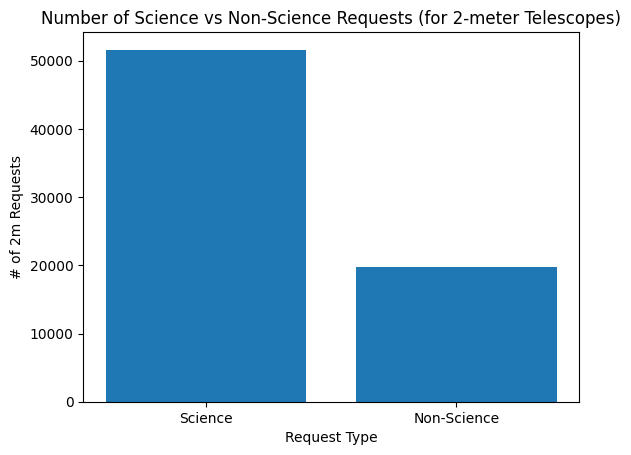

In [58]:
plt.bar(["Science", "Non-Science"], [len(requests), len(calibration)])
plt.title("Number of Science vs Non-Science Requests (for 2-meter Telescopes)")
plt.xlabel("Request Type")
plt.ylabel("# of 2m Requests")
plt.show()

In [59]:
requests

,original_windows,windows,id,ipp_value,created,proposal_id,optimization_type,total_duration,acceptibility_cutoff,valid_telescopes,target_constraint_pairs,og_length,og_window_start,target_types,exposure_types,state,flexibility,theoretical_flexibility
2070067,"[{'start': 2020-02-26 08:00:22.880000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2020-02-26 08:00:...,2070067,0.95,2020-02-26T08:00:25.724Z,KEY2017AB-001,TIME,3345,3344.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 3794395, 'name': 'SN2019xdf...",24.000000,2020-02-26 08:00:22.880,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",COMPLETED,8.689387,25.829596
2074257,"[{'start': 2020-02-29 08:24:00, 'end': 2020-02...",{'2m0a.clma.coj': Timestamp('2020-02-29 12:54:...,2074257,1.05,2020-02-29T08:03:33.408Z,FTPEPO2014A-004,TIME,317,317.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 3810533, 'name': '2016 UJ10...",15.133333,2020-02-29 08:24:00.000,ORBITAL_ELEMENTS,[EXPOSE],COMPLETED,14.195584,171.861199
2071382,"[{'start': 2020-02-27 00:40:20.385000, 'end': ...",{'2m0a.clma.coj': Timestamp('2020-02-27 09:35:...,2071382,1.0,2020-02-27T00:40:23.349Z,LCO2020A-010,TIME,4245,4244.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 3798648, 'name': 'at2019ahk...",24.000000,2020-02-27 00:40:20.385,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",WINDOW_EXPIRED,5.705300,20.353357
2074258,"[{'start': 2020-02-29 08:24:00, 'end': 2020-02...",{'2m0a.clma.coj': Timestamp('2020-02-29 12:54:...,2074258,1.05,2020-02-29T08:04:04.004Z,FTPEPO2014A-004,TIME,317,317.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 3810534, 'name': '2016 UJ10...",15.133333,2020-02-29 08:24:00.000,ORBITAL_ELEMENTS,[EXPOSE],COMPLETED,14.195584,171.861199
2070887,"[{'start': 2020-02-26 11:40:21.209000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2020-02-26 13:39:...,2070887,1.0,2020-02-26T11:40:24.120Z,KEY2017AB-001,TIME,4245,4244.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 3795667, 'name': 'SN 2020cx...",24.000000,2020-02-26 11:40:21.209,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",COMPLETED,1.977856,20.353357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628372,"[{'start': 2021-08-30 18:00:11.734000, 'end': ...",{'2m0a.clma.coj': Timestamp('2021-08-30 18:00:...,2628372,1.0,2021-08-30T18:00:18.984Z,KEY2020B-002,TIME,1845,1844.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6529054, 'name': 'SN2021vtq...",24.000000,2021-08-30 18:00:11.734,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",COMPLETED,21.868293,46.829268
2628924,"[{'start': 2021-08-31 11:55:25.041000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2021-08-31 11:55:...,2628924,1.0,2021-08-31T11:55:29.112Z,NSF2021B-019,TIME,1740,1740.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6533080, 'name': 'ZTF20acgi...",96.000000,2021-08-31 11:55:25.041,ICRS,[EXPOSE],WINDOW_EXPIRED,52.405172,198.620690
2546029,"[{'start': 2021-06-10 00:30:21.276000, 'end': ...",{'2m0a.clma.coj': Timestamp('2021-06-10 12:56:...,2546029,1.0,2021-06-10T00:30:30.609Z,KEY2020B-002,TIME,4245,4244.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6101526, 'name': 'SN2021hku...",24.000000,2021-06-10 00:30:21.276,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",WINDOW_EXPIRED,6.010365,20.353357
2625941,"[{'start': 2021-08-28 00:00:04.674000, 'end': ...",{'2m0a.clma.coj': Timestamp('2021-08-28 13:07:...,2625941,0.9,2021-08-28T00:00:21.972Z,KEY2020B-002,TIME,1245,1244.5,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6516191, 'name': 'SN2021rhu...",24.000000,2021-08-28 00:00:04.674,ICRS,"[SPECTRUM, ARC, LAMP_FLAT]",COMPLETED,36.383133,69.397590


In [60]:
calibration

,original_windows,windows,id,ipp_value,created,proposal_id,optimization_type,total_duration,acceptibility_cutoff,valid_telescopes,target_constraint_pairs,og_length,og_window_start,target_types,exposure_types,state,flexibility,theoretical_flexibility
2074133,"[{'start': 2020-02-29 10:32:42.554000, 'end': ...",{'2m0a.clma.coj': Timestamp('2020-02-29 10:32:...,2074133,1.05,2020-02-29T02:00:40.155Z,auto_focus,TIME,720,720.0,[2m0a.clma.coj],"[{'target': {'id': 3809568, 'name': 'auto_focu...",1.0,2020-02-29 10:32:42.554,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,5.000000,5.000000
2074134,"[{'start': 2020-02-29 11:32:42.554000, 'end': ...",{'2m0a.clma.coj': Timestamp('2020-02-29 11:32:...,2074134,1.05,2020-02-29T02:00:41.027Z,auto_focus,TIME,720,720.0,[2m0a.clma.coj],"[{'target': {'id': 3809569, 'name': 'auto_focu...",1.0,2020-02-29 11:32:42.554,ICRS,[AUTO_FOCUS],COMPLETED,5.000000,5.000000
2149114,"[{'start': 2020-06-13 09:04:44.596000, 'end': ...",{'2m0a.clma.coj': Timestamp('2020-06-13 09:04:...,2149114,1.05,2020-06-13T02:00:42.445Z,auto_focus,TIME,720,720.0,[2m0a.clma.coj],"[{'target': {'id': 4230328, 'name': 'auto_focu...",1.0,2020-06-13 09:04:44.596,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,5.000000,5.000000
2074051,"[{'start': 2020-02-29 11:17:16.861000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2020-02-29 11:17:...,2074051,1.05,2020-02-28T22:00:41.525Z,auto_focus,TIME,720,720.0,[2m0a.clma.ogg],"[{'target': {'id': 3809083, 'name': 'auto_focu...",1.0,2020-02-29 11:17:16.861,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,5.000000,5.000000
2074052,"[{'start': 2020-02-29 12:17:16.861000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2020-02-29 12:17:...,2074052,1.05,2020-02-28T22:00:42.882Z,auto_focus,TIME,720,720.0,[2m0a.clma.ogg],"[{'target': {'id': 3809084, 'name': 'auto_focu...",1.0,2020-02-29 12:17:16.861,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,5.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545965,"[{'start': 2021-06-10 10:59:20.179000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2021-06-10 10:59:...,2545965,1.05,2021-06-09T22:01:01.983Z,auto_focus,TIME,466,466.0,[2m0a.clma.ogg],"[{'target': {'id': 6101076, 'name': 'auto_focu...",1.0,2021-06-10 10:59:20.179,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,7.725322,7.725322
2545966,"[{'start': 2021-06-10 11:59:20.179000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2021-06-10 11:59:...,2545966,1.05,2021-06-09T22:01:03.206Z,auto_focus,TIME,466,466.0,[2m0a.clma.ogg],"[{'target': {'id': 6101077, 'name': 'auto_focu...",1.0,2021-06-10 11:59:20.179,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,7.725322,7.725322
2545967,"[{'start': 2021-06-10 12:59:20.179000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2021-06-10 12:59:...,2545967,1.05,2021-06-09T22:01:04.380Z,auto_focus,TIME,466,466.0,[2m0a.clma.ogg],"[{'target': {'id': 6101078, 'name': 'auto_focu...",1.0,2021-06-10 12:59:20.179,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,7.725322,7.725322
2545968,"[{'start': 2021-06-10 13:59:20.179000, 'end': ...",{'2m0a.clma.ogg': Timestamp('2021-06-10 13:59:...,2545968,1.05,2021-06-09T22:01:05.352Z,auto_focus,TIME,466,466.0,[2m0a.clma.ogg],"[{'target': {'id': 6101079, 'name': 'auto_focu...",1.0,2021-06-10 13:59:20.179,ICRS,[AUTO_FOCUS],WINDOW_EXPIRED,6.474249,7.725322


## Request Duration

### Plot Duration Distribution Quantiles

In [65]:
quantiles = []
steps = []
step = 100
for i in range(int(step)+1):
    q = requests["total_duration"].quantile(i/step)
    print(i/step, q/60)
    quantiles.append(q/60)
    steps.append(i/step)

0.0 3.6166666666666667
0.01 4.2
0.02 4.716666666666667
0.03 5.016666666666667
0.04 5.016666666666667
0.05 5.266666666666667
0.06 5.266666666666667
0.07 5.283333333333333
0.08 5.433333333333334
0.09 5.9
0.1 6.116666666666666
0.11 6.116666666666666
0.12 6.116666666666666
0.13 6.116666666666666
0.14 6.8
0.15 6.8
0.16 6.9
0.17 6.933333333333334
0.18 6.95
0.19 6.95
0.2 6.95
0.21 6.95
0.22 6.95
0.23 6.95
0.24 6.95
0.25 7.033333333333333
0.26 7.566666666666666
0.27 7.566666666666666
0.28 7.75
0.29 7.9
0.3 8.6
0.31 8.6
0.32 8.8
0.33 9.45
0.34 9.8
0.35 10.25
0.36 10.8
0.37 11.1
0.38 11.1
0.39 11.1
0.4 11.1
0.41 11.7
0.42 12.666666666666666
0.43 13.8
0.44 13.966666666666667
0.45 13.966666666666667
0.46 14.266666666666667
0.47 14.85
0.48 15.966666666666667
0.49 17.75
0.5 18.983333333333334
0.51 20.083333333333332
0.52 20.5
0.53 20.5
0.54 21.166666666666668
0.55 23.133333333333333
0.56 24.883333333333333
0.57 25.083333333333332
0.58 25.75
0.59 26.9
0.6 28.3
0.61 28.3
0.62 28.3
0.63 30.083333333333

In [72]:
dur_mean = requests["total_duration"].mean()
dur_std = requests["total_duration"].std()
outlier_limit = dur_mean/60 + 3*dur_std/60
outlier_limit

145.9287357889203

In [76]:
requests[requests["total_duration"] > outlier_limit*60].sort_values("total_duration")

,original_windows,windows,id,ipp_value,created,proposal_id,optimization_type,total_duration,acceptibility_cutoff,valid_telescopes,target_constraint_pairs,og_length,og_window_start,target_types
2364003,"[{'start': 2021-01-22 09:50:00, 'end': 2021-01...",{'2m0a.clma.ogg': Timestamp('2021-01-22 09:50:...,2364003,1.1,2021-01-22T09:46:42.991Z,CON2020B-001,TIME,8790,8790.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 5334956, 'name': 'TOI-620',...",2.450000,2021-01-22 09:50:00,ICRS
2537123,"[{'start': 2021-06-04 07:57:00, 'end': 2021-06...",{'2m0a.clma.ogg': Timestamp('2021-06-04 07:57:...,2537123,1.0,2021-06-04T03:57:08.541Z,KEY2020B-005,TIME,8802,8802.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6066320, 'name': 'TIC 23568...",2.466667,2021-06-04 07:57:00,ICRS
2791853,"[{'start': 2022-02-18 13:02:00, 'end': 2022-02...",{'2m0a.clma.ogg': Timestamp('2022-02-18 13:02:...,2791853,1.16,2022-02-18T03:13:23.163Z,KEY2020B-005,TIME,8838,8838.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 7377856, 'name': 'TIC 21985...",2.633333,2022-02-18 13:02:00,ICRS
2493038,"[{'start': 2021-05-07 07:34:00, 'end': 2021-05...",{'2m0a.clma.ogg': Timestamp('2021-05-07 07:34:...,2493038,1.001,2021-05-07T03:42:53.892Z,KEY2020B-005,TIME,8862,8862.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 5896380, 'name': 'TIC 21985...",2.483333,2021-05-07 07:34:00,ICRS
2116263,"[{'start': 2020-05-07 05:42:00, 'end': 2020-05...",{'2m0a.clma.ogg': Timestamp('2020-05-07 05:42:...,2116263,1.075,2020-05-06T03:42:36.510Z,LCO2020A-008,TIME,8864,8864.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 4050568, 'name': 'TIC 17290...",2.483333,2020-05-07 05:42:00,ICRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705658,"[{'start': 2021-11-11 06:30:00, 'end': 2021-11...",{'2m0a.clma.ogg': Timestamp('2021-11-11 06:30:...,2705658,1.0,2021-11-10T04:04:18.285Z,CON2021B-003,TIME,30380,30380.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 6900190, 'name': 'TOI3763.0...",8.500000,2021-11-11 06:30:00,ICRS
2975295,"[{'start': 2022-08-17 06:06:00, 'end': 2022-08...",{'2m0a.clma.ogg': Timestamp('2022-08-17 06:06:...,2975295,1.21,2022-08-17T03:43:36.477Z,KEY2020B-005,TIME,31086,31086.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 8333389, 'name': 'TIC 25678...",9.116667,2022-08-17 06:06:00,ICRS
3056816,"[{'start': 2022-11-18 06:30:00, 'end': 2022-11...",{'2m0a.clma.ogg': Timestamp('2022-11-18 06:30:...,3056816,1.09,2022-11-18T06:06:25.170Z,CON2022B-003,TIME,31499,31499.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 8784286, 'name': 'V1298Tau'...",8.750000,2022-11-18 06:30:00,ICRS
3056739,"[{'start': 2022-11-18 06:20:00, 'end': 2022-11...",{'2m0a.clma.ogg': Timestamp('2022-11-18 06:20:...,3056739,1.1,2022-11-18T03:56:05.961Z,CON2022B-003,TIME,31799,31799.0,"[2m0a.clma.coj, 2m0a.clma.ogg]","[{'target': {'id': 8783888, 'name': 'V1298Tau'...",8.833333,2022-11-18 06:20:00,ICRS


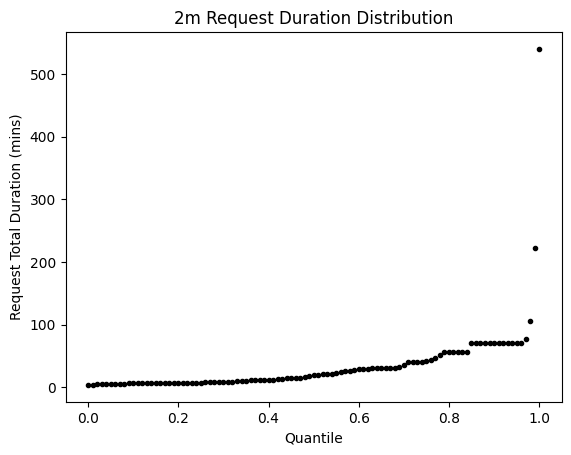

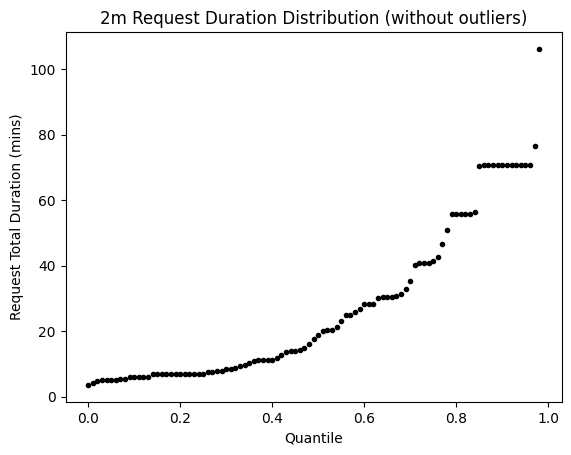

In [60]:
scatter(steps, quantiles,
        "2m Request Duration Distribution",
        "Quantile",
        "Request Total Duration (mins)",
        "2m_duration_distribution")

scatter(steps[:-2], quantiles[:-2],
        "2m Request Duration Distribution (without outliers)",
        "Quantile",
        "Request Total Duration (mins)",
        "2m_duration_distribution_without_outliers")

### Suggest Values to split the durations
Splitting into Small, Medium, and Large distributions

Using boundaries of 600 and 1800 gives us a 35%, 38%, 27% split.

0 -> 600: 17847
600 -> 1800: 14618
1800 -> inf: 19141


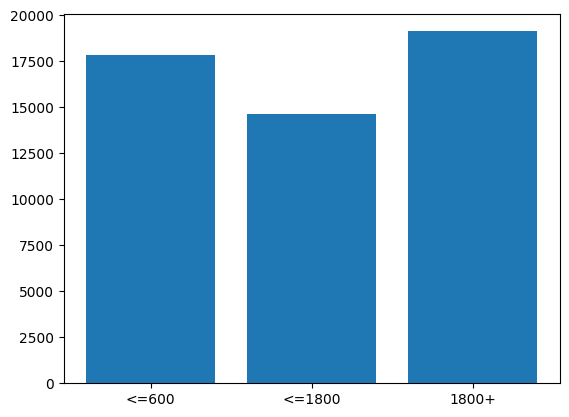

In [39]:
split_on_limits(requests, "total_duration", [0, 600, 1800])

0 -> 600: 6988
600 -> 1800: 12744
1800 -> inf: 26


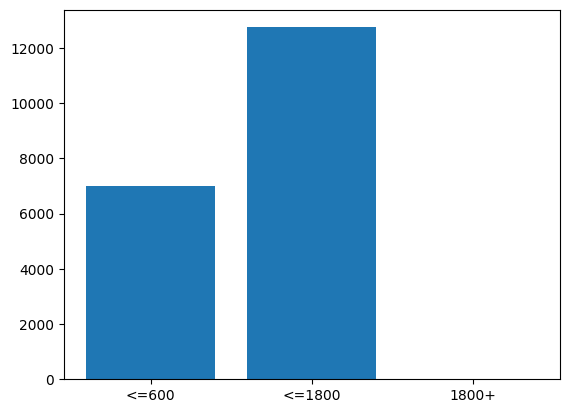

In [52]:
split_on_limits(calibration, "total_duration", [0, 600, 1800])

### Split by Target Type

Index(['ICRS', 'ORBITAL_ELEMENTS', 'BOTH'], dtype='object', name='target_types')
[49880, 1660, 66]


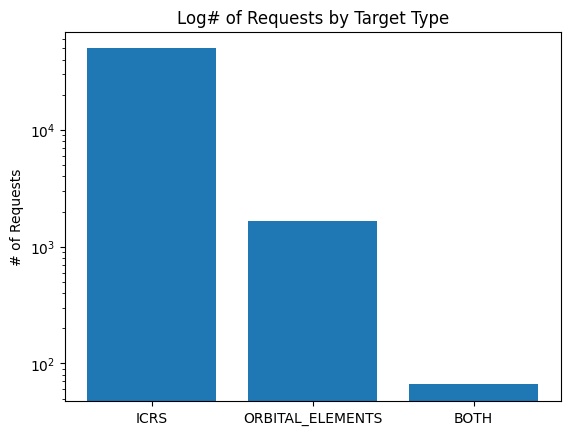

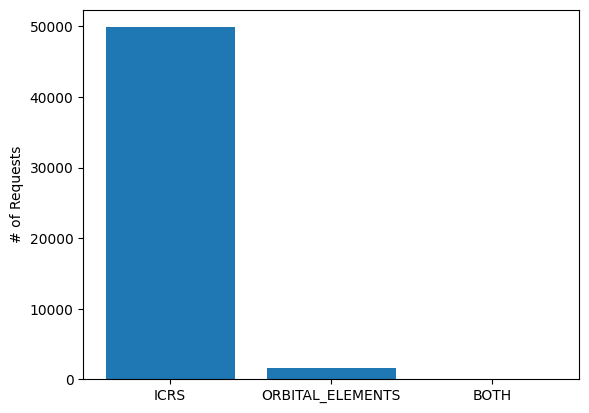

In [40]:
target_types = requests["target_types"].value_counts()
print(target_types.index)
print(requests["target_types"].value_counts().to_list())

plt.bar([x for x in target_types.index], target_types.to_list())
plt.title("Log# of Requests by Target Type")
plt.yscale("log")
plt.ylabel("# of Requests")
plt.show()

plt.bar([x for x in target_types.index], target_types.to_list())
plt.ylabel("# of Requests")
plt.show()

### Duration vs Target Type

## Availability Windows

### Plot Availability Window Distribution

In [47]:
quantiles = []
steps = []
step = 50
for i in range(int(step)+1):
    q = requests["og_length"].quantile(i/step)
    # print(i/step, q)
    quantiles.append(q)
    steps.append(i/step)

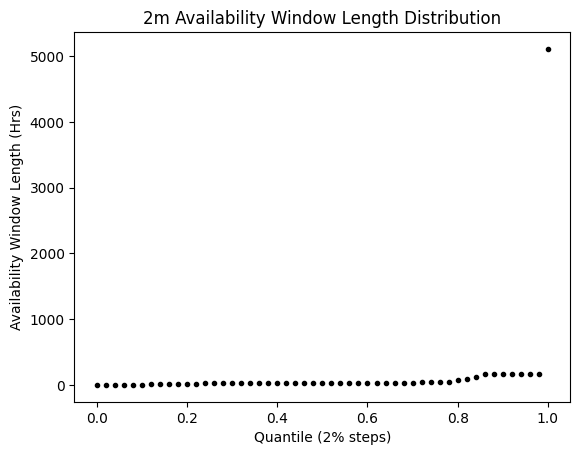

In [48]:
scatter(steps, quantiles,
        "2m Availability Window Length Distribution",
        "Quantile (2% steps)",
        "Availability Window Length (Hrs)",
        "2m_availability_window_length_distribution")

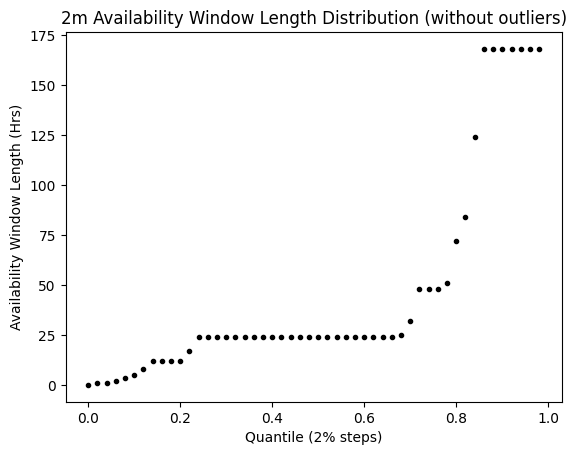

In [49]:
scatter(steps[:-1], quantiles[:-1],
        "2m Availability Window Length Distribution (without outliers)",
        "Quantile (2% steps)",
        "Availability Window Length (Hrs)",
        "2m_availability_window_length_distribution_without_outliers")

### Suggest values to split availability windows

Determining what values to use to set as the availability windows to test.

Using boundaries of 1hr and 24hrs gives us a 27%, 49%, 23% split.

In [12]:
split_on_limits(requests, "og_length", [0, 1, 24, 72, 168])

NameError: name 'requests' is not defined

0 -> 1: 17025
1 -> 24: 2685
24 -> 168: 47
168 -> inf: 1


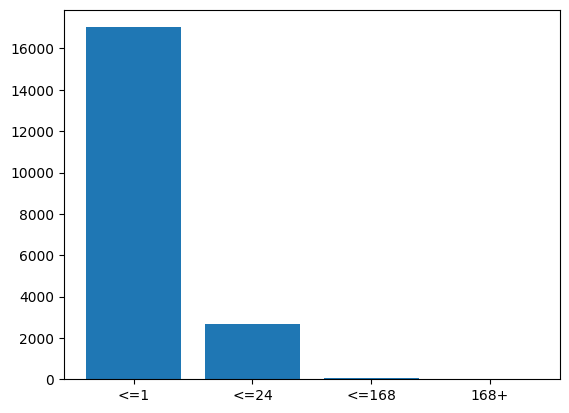

In [51]:
split_on_limits(calibration, "og_length", [0, 1, 24, 168])

0 1 19380
1 24 35225
24 168 15832
168 100000000 943


<BarContainer object of 4 artists>

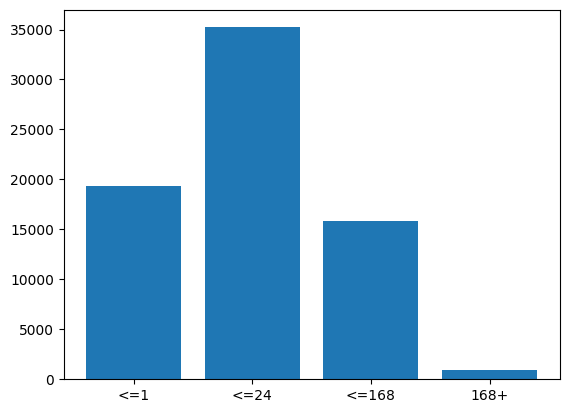

In [60]:
avw_limits = [0, 1, 24, 168]
avw_counts = []
for i in range(len(avw_limits)):
    bottom_limit = avw_limits[i]
    if (i+1) < len(avw_limits):
        top_limit = avw_limits[i+1]
    else:
        top_limit = 100000000
    avw_counts.append(requests[(requests["og_length"]>bottom_limit) & (requests["og_length"]<=top_limit)].shape[0])

    print(bottom_limit, top_limit, avw_counts[i])

labels = ["<="+str(x) for x in avw_limits[1:]]
labels.append(str(avw_limits[-1]) + "+")

plt.bar(labels, avw_counts)

0 0.2 175
0.2 0.5 662
0.5 1 18543
1 6 3339
6 16 7435
16 24 24451
24 48 4873
48 72 2502
72 96 771
96 120 356
120 144 287
144 168 7043
168 100000000 943


<BarContainer object of 13 artists>

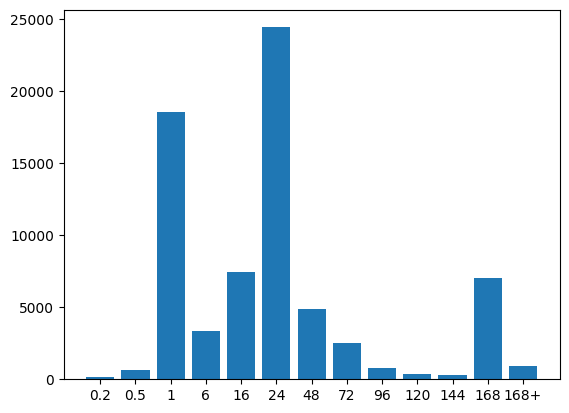

In [103]:
avw_limits = [0, 0.2, 0.5, 1, 6, 16, 24, 48, 72, 96, 120, 144, 168]
avw_counts = []
for i in range(len(avw_limits)):
    bottom_limit = avw_limits[i]
    if (i+1) < len(avw_limits):
        top_limit = avw_limits[i+1]
    else:
        top_limit = 100000000
    avw_counts.append(requests[(requests["og_length"]>bottom_limit) & (requests["og_length"]<=top_limit)].shape[0])

    print(bottom_limit, top_limit, avw_counts[i])

labels = [str(x) for x in avw_limits[1:]]
labels.append(str(avw_limits[-1]) + "+")

plt.bar(labels, avw_counts)

### Availability Windows with Target

0 0.2 174
0.2 0.5 600
0.5 1 18240
1 6 3107
6 16 7056
16 24 24024
24 48 4783
48 72 2450
72 96 733
96 120 341
120 144 244
144 168 7010
168 100000000 874


Text(0.5, 1.0, 'Availability Windows for ICRS Targets')

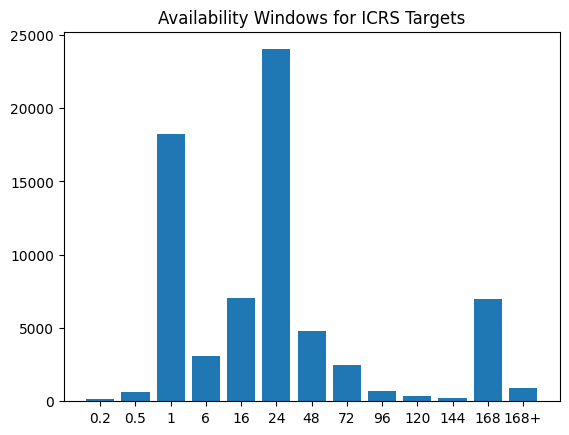

In [102]:
# ICRS Targets
vv1 = requests[requests["target_types"] == ('ICRS',)]

avw_limits = [0, 0.2, 0.5, 1, 6, 16, 24, 48, 72, 96, 120, 144, 168]
avw_counts = []
for i in range(len(avw_limits)):
    bottom_limit = avw_limits[i]
    if (i+1) < len(avw_limits):
        top_limit = avw_limits[i+1]
    else:
        top_limit = 100000000
    avw_counts.append(vv1[(vv1["og_length"]>bottom_limit) & (vv1["og_length"]<=top_limit)].shape[0])

    print(bottom_limit, top_limit, avw_counts[i])

labels = [str(x) for x in avw_limits[1:]]
labels.append(str(avw_limits[-1]) + "+")

plt.bar(labels, avw_counts)
plt.title("Availability Windows for ICRS Targets")

In [95]:
vv1["og_length"].quantile(0.42)

16.125

0 0.2 1
0.2 0.5 62
0.5 1 303
1 6 204
6 16 349
16 24 425
24 48 88
48 72 52
72 96 35
96 120 15
120 144 39
144 168 33
168 100000000 66


Text(0.5, 1.0, 'Availability Windows for ORBITAL_ELEMENTS Targets')

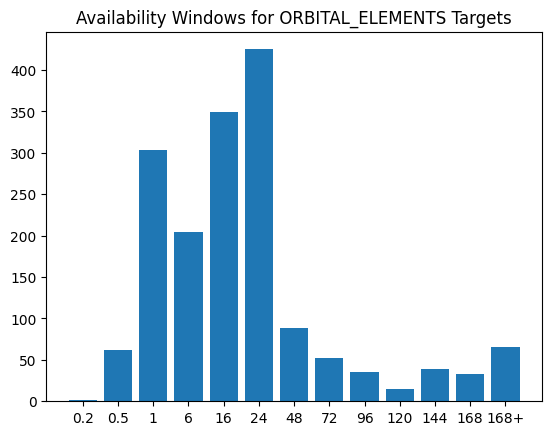

In [101]:
# Orbiting Element Targets
vv2 = requests[requests["target_types"] == ('ORBITAL_ELEMENTS',)]

avw_limits = [0, 0.2, 0.5, 1, 6, 16, 24, 48, 72, 96, 120, 144, 168]
avw_counts = []
for i in range(len(avw_limits)):
    bottom_limit = avw_limits[i]
    if (i+1) < len(avw_limits):
        top_limit = avw_limits[i+1]
    else:
        top_limit = 100000000
    avw_counts.append(vv2[(vv2["og_length"]>bottom_limit) & (vv2["og_length"]<=top_limit)].shape[0])

    print(bottom_limit, top_limit, avw_counts[i])

labels = [str(x) for x in avw_limits[1:]]
labels.append(str(avw_limits[-1]) + "+")

plt.bar(labels, avw_counts)
plt.title("Availability Windows for ORBITAL_ELEMENTS Targets")

In [100]:
vv2["og_length"].quantile(0.54)

16.0

In [7]:
weights = [4, 4, 4, 1]
for w in weights:
    print(w / sum(weights)*71380/6)

3660.512820512821
3660.512820512821
3660.512820512821
915.1282051282052


In [105]:
for j in range(0, 11, 2):
    i = j/10
    print(f"{i}->{i+0.2}", requests[(requests["og_length"]>=i)&(requests["og_length"]<i+0.2)].shape)

0.0->0.2 (147, 12)
0.2->0.4 (364, 12)
0.4->0.6000000000000001 (471, 12)
0.6->0.8 (148, 12)
0.8->1.0 (162, 12)
1.0->1.2 (18362, 12)


In [101]:
requests[requests["og_length"]<=1.0].value_counts("og_length").head(20)

og_length
1.000000    18196
0.500000      159
0.333333      135
0.800000      124
0.600000      108
0.250000       96
0.433333       93
0.066667       43
0.416667       39
0.300000       31
0.166667       29
0.200000       28
0.233333       20
0.100000       20
0.666667       19
0.150000       18
0.216667       16
0.400000       15
0.750000       14
0.450000       13
Name: count, dtype: int64

### Availability Histogram

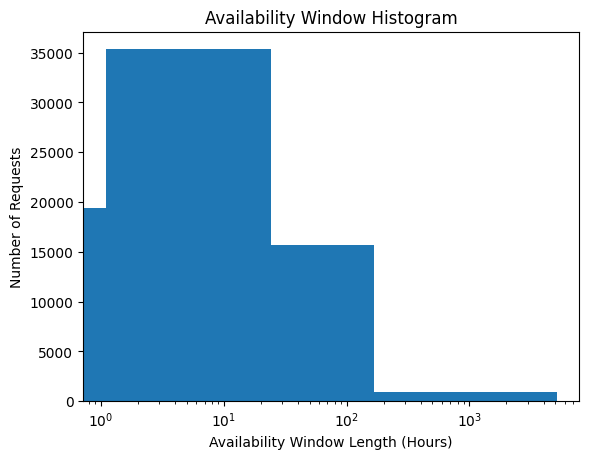

In [44]:
max_val = requests["og_length"].max()
histogram(requests["og_length"],
          [0, 1.1, 24.1, 168.1, max_val],
          "Availability Window Histogram",
          "Availability Window Length (Hours)",
          "Number of Requests",
          "")

In [51]:
requests[requests["og_length"]>200].sort_values("og_length")["og_length"]

2422236     200.766667
2380149     200.938889
2107503     202.883333
2107572     202.883333
2107573     202.883333
              ...     
2172119    5087.995000
2172120    5087.995000
2172015    5087.998056
2170842    5111.983889
2170857    5111.993056
Name: og_length, Length: 630, dtype: float64

(array([ 534, 1637,  463, ...,    0,    0,    2]), array([1.52527778e+00, 2.81417255e+00, 4.10306733e+00, ...,
       5.10941527e+03, 5.11070416e+03, 5.11199306e+03]))


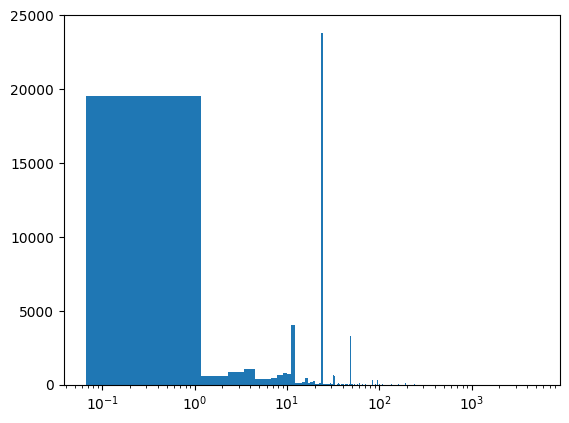

In [73]:
print(np.histogram(requests[requests["og_length"]>1.5]["og_length"], bins="auto"))
plt.hist(requests["og_length"], bins="auto")
# plt.yscale("log")
plt.xscale("log")
plt.show()

(1.0, 35000.0)

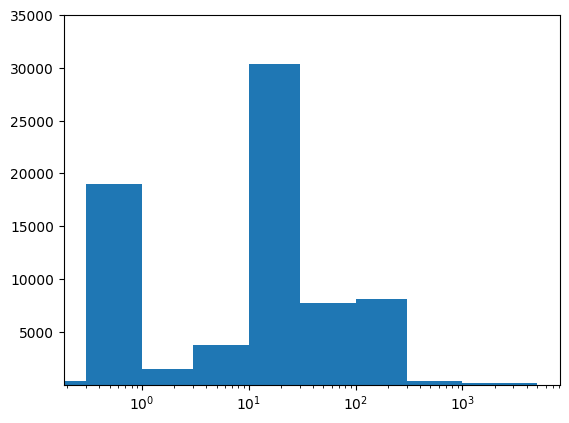

In [78]:
eps = 10**(-5)
bins = [0, 0.3+eps, 1+eps, 3+eps, 10+eps, 30+eps, 100+eps, 300+eps, 1000+eps, 5000+eps]
x = requests["og_length"]
plt.hist(x, bins=bins)

# x = requests["og_length"]
# _, bins = np.histogram(x, bins="auto")
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.hist(x, bins=logbins)
plt.xscale("log")
# plt.yscale("log")
plt.ylim(1, 35000)

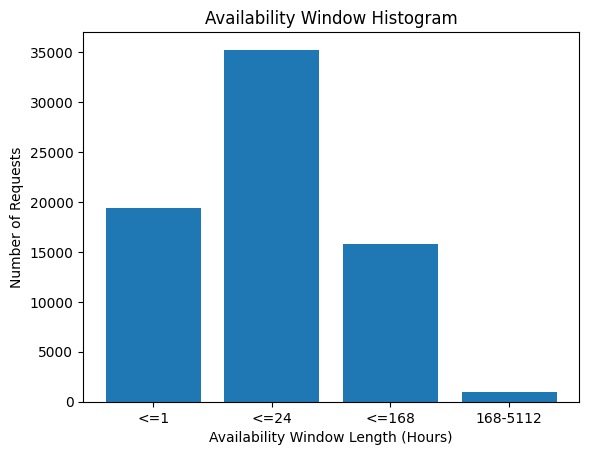

In [66]:
max_value = round(requests["og_length"].max())
flat_hist(requests["og_length"],
          [0, 1.01, 24.01, 168.01, 10000000],
          ["<=1", "<=24", "<=168", f"168-{max_value}"],
          "Availability Window Histogram",
          "Availability Window Length (Hours)",
          "Number of Requests",
          "")

In [107]:
from dateutil.relativedelta import relativedelta

2020-08-01 00:00:00 529
2020-09-01 00:00:00 412
2020-10-01 00:00:00 522
2020-11-01 00:00:00 487
2020-12-01 00:00:00 503
2021-01-01 00:00:00 510
2021-02-01 00:00:00 410
2021-03-01 00:00:00 362
2021-04-01 00:00:00 644
2021-05-01 00:00:00 787
2021-06-01 00:00:00 530
2021-07-01 00:00:00 624
2021-08-01 00:00:00 667
2021-09-01 00:00:00 517
2021-10-01 00:00:00 563
2021-11-01 00:00:00 518
2021-12-01 00:00:00 491
2022-01-01 00:00:00 514
2022-02-01 00:00:00 486
2022-03-01 00:00:00 545
2022-04-01 00:00:00 533
2022-05-01 00:00:00 474
2022-06-01 00:00:00 397
2022-07-01 00:00:00 314


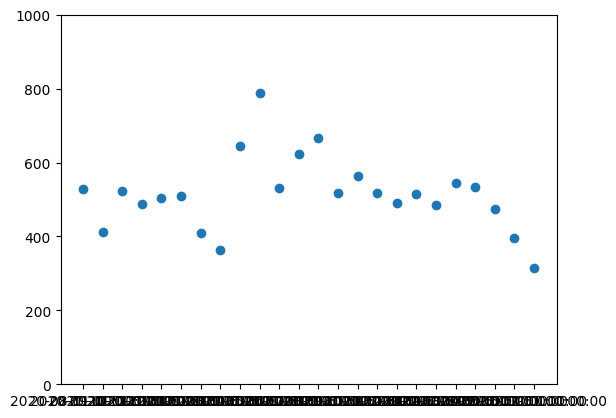

In [121]:
short = requests[requests["og_length"]<=1.0]

start_dates = []
month_start = dt.datetime(2020, 8, 1)
while month_start < dt.datetime(2022, 8, 2):
    start_dates.append(month_start)
    month_start += relativedelta(months=1)

counts = []

for i in range(len(start_dates)-1):
    start = start_dates[i]
    end = start_dates[i+1]
    month_requests = short[(short["og_window_start"]>start) & (short["og_window_start"]<end)]
    counts.append(len(month_requests))
    print(start, len(month_requests))

plt.scatter([str(x) for x in start_dates[:-1]], counts)
plt.ylim(0, 1000)
plt.show()
    
    


# to_timestamp = np.vectorize(lambda x: x.timestamp())
# time_stamps = to_timestamp(dt_array)
# np.histogram(time_stamps)

## Proposal Priority

### Plot Proposal Priority Distribution

,active,title,abstract,tac_priority,tac_rank,public,non_science,direct_submission,sca_id,tags
id,,,,,,,,,,
LCOELP-002,False,Active W UMa stars,,50,0,False,False,False,LCOGT,{}
CON2018A-006,False,AGN Reverberation Lags,,25,6,False,False,False,LCOGT,{}
DDTELP-003,False,Astrophotography,,50,0,False,False,False,LCOGT,{}
DDT2020A-004,False,Catch a Fading Star 2: High-Cadence Photometry...,,20,4,False,False,False,LCO,{}
TAU2019B-007,False,changing-look AGNs,,20,7,False,False,False,TAU,{}
...,...,...,...,...,...,...,...,...,...,...
SOAR2023B-020,False,Very Rapid-Response Spectroscopy of Supernovae...,,20,20,False,False,False,SOAR,{}
FTPEPO2021A-001,True,"Consolidated Activities Regarding Moon, Earth ...",,13,1,True,False,False,FTP,{public}
KEY2023B-005,True,LCO follow up of TESS transiting planet candid...,,30,5,False,False,False,SCICOLLAB,{}


In [19]:
quantiles = []
steps = []
step = 50
for i in range(int(step)+1):
    q = proposals_2m["tac_priority"].quantile(i/step)
    print(i/step, q)
    quantiles.append(q)
    steps.append(i/step)

0.0 10.0
0.02 10.0
0.04 11.0
0.06 11.0
0.08 12.0
0.1 12.5
0.12 13.0
0.14 13.0
0.16 15.0
0.18 16.0
0.2 18.0
0.22 18.0
0.24 19.0
0.26 19.0
0.28 19.000000000000007
0.3 20.0
0.32 20.0
0.34 20.0
0.36 21.0
0.38 21.0
0.4 22.0
0.42 22.0
0.44 22.0
0.46 24.0
0.48 24.0
0.5 25.0
0.52 25.0
0.54 25.0
0.56 25.0
0.58 25.0
0.6 25.0
0.62 25.0
0.64 25.0
0.66 25.0
0.68 25.0
0.7 25.0
0.72 25.0
0.74 25.5
0.76 26.0
0.78 27.0
0.8 28.0
0.82 28.0
0.84 28.0
0.86 29.0
0.88 29.0
0.9 30.0
0.92 30.0
0.94 30.0
0.96 33.0
0.98 550.0
1.0 10000.0


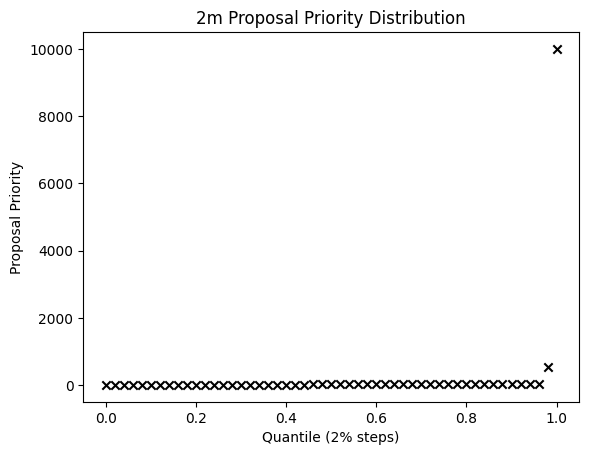

In [20]:
scatter(steps, quantiles,
        "2m Proposal Priority Distribution",
        "Quantile (2% steps)",
        "Proposal Priority",
        "2m_proposal_priority_distribution")

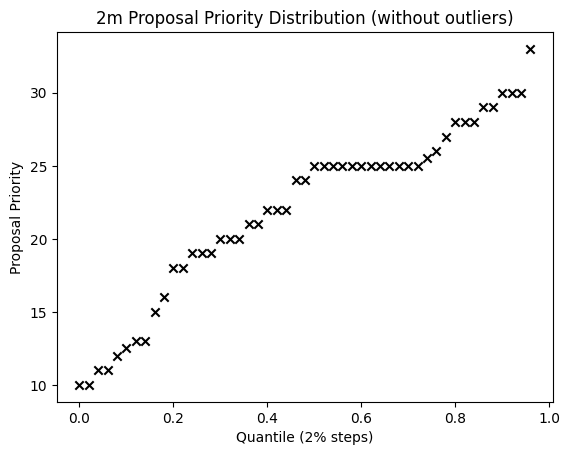

In [21]:
scatter(steps[:-2], quantiles[:-2],
        "2m Proposal Priority Distribution (without outliers)",
        "Quantile (2% steps)",
        "Proposal Priority",
        "2m_proposal_priority_distribution_without_outliers")

### Suggest Values to split Priorities
Determining what priority values to use to divide the proposals into bands.

Using boundaries of 20 and 25 gives us a 36%, 39%, 24% split.

In [22]:
proposals_2m.sort_values("tac_priority", ascending=False)[["tac_priority"]].head(10)

,tac_priority
id,
NSF2022A-009,10000
COJ_calib,1000
OGG_calib,1000
LCOEngineering,1000
FLOYDS standards,100
MuSCAT Commissioning,40
KEY2020B-002,35
DDT2021A-011,33
SUPA2021A-006,30


In [23]:
req_proposals = proposals_2m.drop(index=["COJ_calib", "OGG_calib", 
                                         "LCOEngineering", "FLOYDS standards",
                                         "MuSCAT Commissioning"])

prop_short = req_proposals[req_proposals["tac_priority"] <= 20.0]
prop_medium = req_proposals[(20.0 < req_proposals["tac_priority"]) & (req_proposals["tac_priority"] <= 25.0)]
prop_long = req_proposals[25.0 < req_proposals["tac_priority"]]

counts = [len(prop_short), len(prop_medium), len(prop_long)]
for c in counts:
    print(c/sum(counts)*100)

36.25730994152047
39.76608187134503
23.976608187134502


In [34]:
proposals_2m[proposals_2m["non_science"]].index.tolist()

['OGG_calib',
 'standard',
 'auto_focus',
 'LCOEngineering',
 'COJ_calib',
 'FLOYDS standards',
 'Photometric standards']

## Flexibility

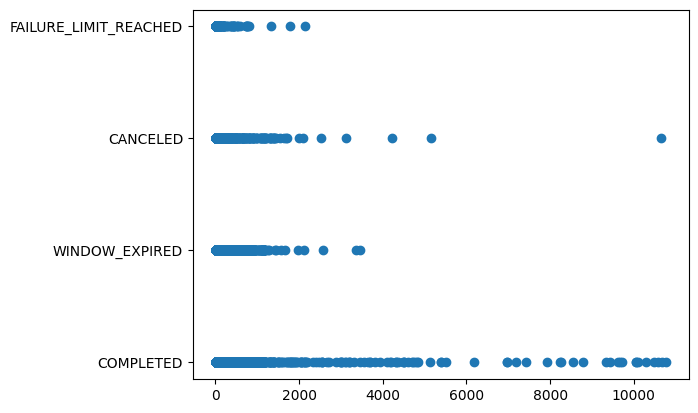

In [66]:
plt.scatter(requests["flexibility"], requests["state"])

In [67]:
requests.value_counts("state")

state
WINDOW_EXPIRED           29686
COMPLETED                16912
CANCELED                  4587
FAILURE_LIMIT_REACHED      421
Name: count, dtype: int64

Not sure how to represent this. But it looks like more flexible observations ARE getting scheduled, at least on the 2m telescopes, while the less flexible observations are more likely to get cancelled. This is a scenario that makes sense if the telescope is undersubscribed, as there should be enough space to fit everything in eventually.

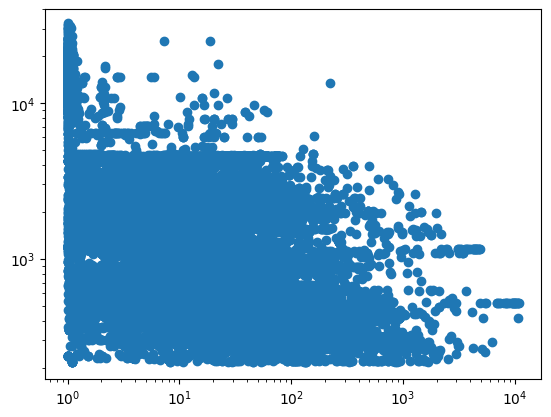

In [82]:
plt.scatter(requests["flexibility"], requests["total_duration"])
plt.yscale("log")
plt.ylim([170, 40000])
plt.xscale("log")
plt.show()

In [76]:
requests["total_duration"].max()

32399

In [83]:
request_data

,id,state
0,3053362,WINDOW_EXPIRED
1,3097579,COMPLETED
2,3057472,COMPLETED
3,3112564,COMPLETED
4,3112973,COMPLETED
...,...,...
1062601,2327326,WINDOW_EXPIRED
1062602,2327327,WINDOW_EXPIRED
1062603,2327328,COMPLETED
1062604,2327329,COMPLETED


In [86]:
a1 = pd.read_pickle("condensed_2m/2m_large_all.pkldf")

In [87]:
a1.columns

Index(['original_windows', 'windows', 'id', 'ipp_value', 'created',
       'proposal_id', 'optimization_type', 'total_duration',
       'acceptibility_cutoff', 'valid_telescopes', 'target_constraint_pairs'],
      dtype='object')